# TRAFFIC SIGN

Student: Scarpato Alessandro 5206880

The current dataset, titled 'Traffic Signs Dataset in YOLO format,' comprises 741 images showcasing roades and panoramas, each featuring one or more traffic signs. These signs are categorized into 3 classes:
0.   Prohibitory
1.   Danger
2.   Mandatory
3.   Other

The project aims to develop a model proficient in classifying road signs within images. To accomplish this goal, I'll be implementing a Convolutional Neural Network (CNN). A CNN is a specialized neural network crafted for processing and identifying patterns in two-dimensional data, like images. This involves utilizing convolutional filters, enabling the network to grasp specific image features such as edges and shapes. Essentially, this architecture empowers the network to discern and comprehend intricate patterns within images, enhancing its effectiveness in visual classification tasks, such as the recognition of road signs


## LOADING THE DATA

First and foremost, it is advisable to download the necessary packages and libraries that will be used throughout the project. In particular, the PyTorch library will be extensively leveraged.
PyTorch is an open-source machine learning library widely used for tasks such as deep learning and neural network implementations. It provides a flexible and dynamic computational graph, making it easier to define and modify complex models. PyTorch is known for its intuitive syntax, extensive community support, and seamless integration with hardware accelerators, making it a popular choice for researchers and developers in the field of artificial intelligence.

In [1]:
%%capture
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import seaborn as sns
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

!pip install d2l==1.0.0a1.post0
from d2l import torch as d2l

!pip install opencv-python

%matplotlib inline

The code drive.mount('/content/drive') in Google Colab is utilized to mount Google Drive into the runtime session. This enables access to files on Google Drive directly from the notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



The command %cd "/content/drive/MyDrive/deep learning/archive /ts/ts" is used to change the current working directory to the specified path. In this case, it navigates to the directory "/content/drive/MyDrive/deep learning/archive /ts/ts".

In [3]:
%cd  "/content/drive/MyDrive/deep learning/archive /ts/ts"


/content/drive/MyDrive/deep learning/archive /ts/ts


This code lists all files in the current directory, sorts them, and then creates separate lists for image files with the '.jpg' extension and text files with the '.txt' extension.


In [4]:
file_list = sorted(os.listdir())
image_files = [file for file in file_list if file.lower().endswith(('.jpg'))]
text_files = [file for file in file_list if file.lower().endswith((".txt"))]

Let's show an image example of our dataset

In [5]:
Image.open(image_files[1])

Output hidden; open in https://colab.research.google.com to view.

Let's now create a dataframe from our initial dataset

In [6]:
# Function to read content from a text file
def read_text_file(text_file):
    with open(text_file, 'r') as file:
        lines = file.readlines()

    folder_contents = []
    for line in lines:
        data = line.strip().split()
        folder = {
            "Number": int(data[0]),
            "X": float(data[1]),
            "Y": float(data[2]),
            "Width": float(data[3]),
            "Height": float(data[4])
        }
        folder_contents.append(folder)

    return folder_contents

# Function to create a DataFrame from image and text files
def create_dataset_df(image_files, text_files):
    # Initialize an empty dataset dictionary
    dataset = {"Image": [], "Label": [], "X": [], "Y": [], "Width": [], "Height": []}

    # Iterate through pairs of text and image files
    for text_file, image_file in zip(text_files, image_files):
        # Read content from the text file
        folder_contents = read_text_file(text_file)

        # Populate the dataset dictionary with relevant information
        for content in folder_contents:
            dataset["Image"].append(image_file)
            dataset["Label"].append(content["Number"])
            dataset["X"].append(content["X"])
            dataset["Y"].append(content["Y"])
            dataset["Width"].append(content["Width"])
            dataset["Height"].append(content["Height"])

    # Convert the dataset dictionary to a Pandas DataFrame
    df = pd.DataFrame(dataset)

    return df

# Create a DataFrame from image and text files
df = create_dataset_df(image_files, text_files)

This code defines two functions: read_text_file to extract information from a text file and create_dataset_df to create a DataFrame from image and text files. The resulting DataFrame (df) will be helpful for verifying the dataset's balance.

In [7]:
# Print the first few rows of the DataFrame
print(df.head())
# Print the total number of rows in the DataFrame
print("Total number of rows in the DataFrame:", len(df))


       Image  Label         X         Y     Width   Height
0  00000.jpg      1  0.584191  0.535625  0.030147  0.04375
1  00001.jpg      2  0.737868  0.512500  0.030147  0.05500
2  00001.jpg      2  0.304412  0.653750  0.041176  0.07250
3  00001.jpg      3  0.736765  0.453125  0.042647  0.06875
4  00002.jpg      2  0.697794  0.667500  0.083824  0.14500
Total number of rows in the DataFrame: 1213


as we can see, the dataframer we created contains 1213 rows which means there are 1213 signs and 6 columns:
1.   image: The name of the image file associated with the sign.
2.   label: The numerical label indicating the type of sign.
3.   X: The X-coordinate of the sign's bounding box.
4.   Y: The Y-coordinate of the sign's bounding box.
5.   Width: The width of the sign's bounding box.
6.   Height: The height of the sign's bounding box.



In [8]:
label_counts = df['Label'].value_counts()
label_counts

0    557
3    274
1    219
2    163
Name: Label, dtype: int64

This code serves the purpose of assessing the dataset's balance. As observed, a notable prevalence of signs with label 0 is evident. However, before drawing any conclusions, let's proceed with visualizing the distribution through a graph

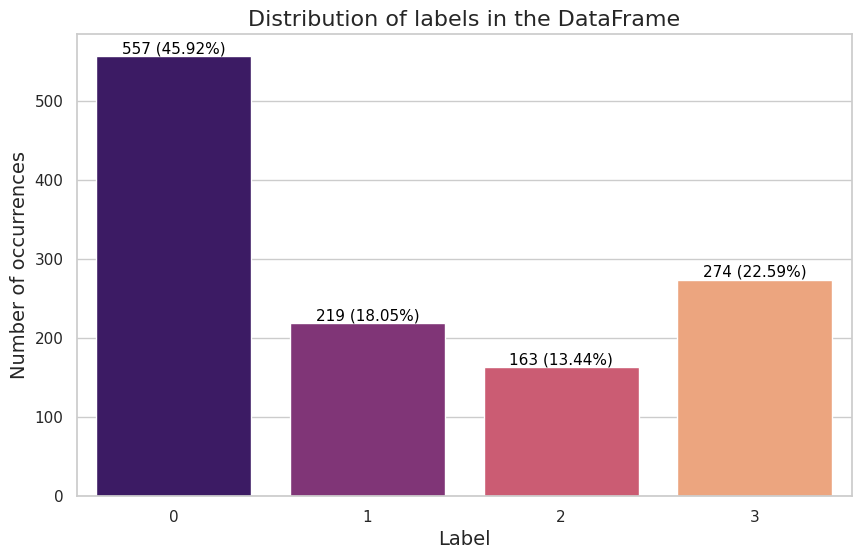

In [9]:
# Sort the index
label_counts = label_counts.sort_index()

# Calculate percentages relative to the total
percentages = label_counts / label_counts.sum() * 100

# Set a seaborn style
sns.set(style="whitegrid")

# Create a bar plot with seaborn
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=label_counts.index, y=label_counts.values, palette="magma")

# Add labels and title
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of occurrences', fontsize=14)
plt.title('Distribution of labels in the DataFrame', fontsize=16)

# Add annotations for each bar
for bar, count, percentage in zip(plot.patches, label_counts.values, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1,
             f"{count} ({percentage:.2f}%)", ha='center', va='bottom', color='black', fontsize=11)

# Show the plot
plt.show()

As evident from the graph, there is an imbalance in the dataset, with prohibitory signs representing over 45% of the observations. This imbalance poses potential challenges during model training, as the model may become biased towards the dominant class. To address this issue, we will reduct the number of images with label 0

## EXAMPLE

Let's print an example of bounding boxes on an image

In this code snippet, an image is read using the OpenCV library, and information about its type and shape is displayed. The spatial dimensions (height and width) of the image are then extracted and printed

In [10]:
# Reading image with OpenCV library
image_BGR = cv2.imread('/content/drive/MyDrive/deep learning/archive /ts/ts/00001.jpg')

# Showing image shape
print('Image type:', type(image_BGR))
print('Image shape:', image_BGR.shape)

# Getting spatial dimension of input image
h, w = image_BGR.shape[:2]  # Slicing from tuple only first two elements

# Showing height an width of image
print('Image height={0} and width={1}'.format(h, w))

Image type: <class 'numpy.ndarray'>
Image shape: (800, 1360, 3)
Image height=800 and width=1360


*   Image type: The type of the image_BGR variable is a NumPy array (<class 'numpy.
ndarray'>). A numpy.ndarray is a multi-dimensional data structure provided by the NumPy library in Python. It supports arrays of varying dimensions, ensuring elements are of the same data type.
*   Image shape: The shape of the image_BGR array is (800, 1360, 3), representing the image dimensions in pixels. The third dimension (3) corresponds to the three color channels (BGR) of the image.
*   Image height and width: The height of the image is 800 pixels, and the width is 1360 pixels. These values provide information about the spatial dimensions of the image.




This code retrieves textual information associated with image 00001. Utilizing this information, it delineates bounding boxes and adds labels around the traffic signs.

In [11]:
# Opening and reading the YOLO annotation file
with open('/content/drive/MyDrive/deep learning/archive /ts/ts/00001.txt') as f:
    # Preparing a list for annotation of bounding boxes (BB)
    lst = []
    for line in f:
        lst += [line.rstrip()]
        print(line)

# Going through all bounding boxes
for i in range(len(lst)):
    # Getting current bounding box coordinates, its width, and height
    bb_current = lst[i].split()
    x_center, y_center = int(float(bb_current[1]) * w), int(float(bb_current[2]) * h)
    box_width, box_height = int(float(bb_current[3]) * w), int(float(bb_current[4]) * h)

    # Extracting top-left corner coordinates (x_min, y_min) from YOLO data format
    x_min = int(x_center - (box_width / 2))
    y_min = int(y_center - (box_height / 2))

    # Drawing bounding box on the original image
    cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [172, 10, 127], 2)

    # Preparing text with label for the current bounding box
    class_current = 'Class: {}'.format(bb_current[0])

    # Displaying label text near the bounding box
    cv2.putText(image_BGR, class_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [172, 10, 127], 2)


2 0.7378676470588236 0.5125 0.030147058823529412 0.055

2 0.3044117647058823 0.65375 0.041176470588235294 0.0725

3 0.736764705882353 0.453125 0.04264705882352941 0.06875



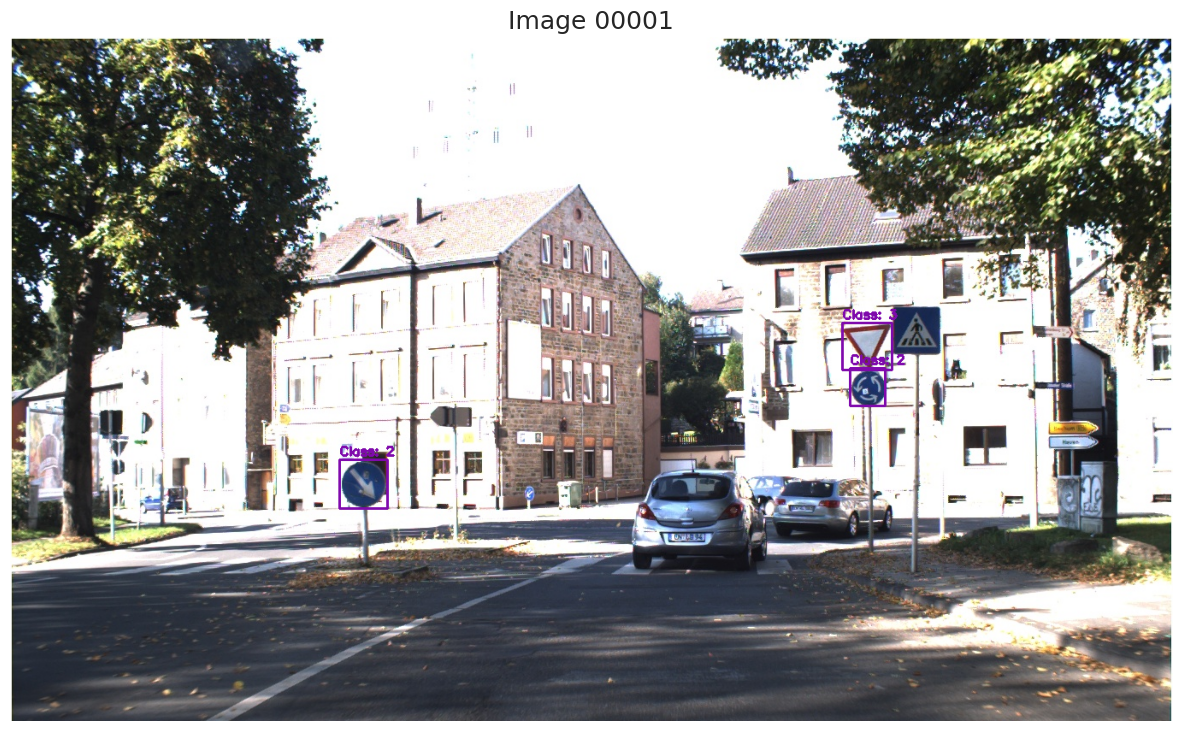

In [12]:
# Setting default size of the plot
plt.rcParams['figure.figsize'] = (15, 15)

# Initializing the plot
fig = plt.figure()

plt.imshow(cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image 00001', fontsize=18)

# Showing the plot
plt.show()

As we can see from the image, the traffic signs are surrounded by squares called bounding boxes.
Bounding boxes are rectangular frames or regions defined by two sets of coordinates, typically representing the top-left and bottom-right corners. These boxes are used to encapsulate and identify specific objects within an image. Bounding boxes play a crucial role in computer vision tasks, such as object detection and localization. They provide a structured way to indicate the spatial extent of objects, facilitating the training and evaluation of machine learning models.

## REGION OF INTEREST

To conduct image classification effectively, it is essential to focus on specific regions of interest. In this regard, the following code selectively extracts traffic signs from the images, saving them into a dedicated folder named 'sign'. Defining ROIs is essential for targeted operations, such as feature extraction, object detection, or classification. It allows algorithms to concentrate computational resources on relevant portions of an image, enhancing efficiency and accuracy. ROIs are particularly valuable when dealing with complex scenes, as they enable the algorithm to focus on the most informative and pertinent areas, leading to more effective image analysis and interpretation.

    def extract_rois(df, image_folder, output_folder):
        for index, row in df.iterrows():
            image_path = os.path.join(image_folder, row['Image'])
            image_BGR = cv2.imread(image_path)

        with open(os.path.join(image_folder, row['Image'].replace('.jpg', '.txt'))) as f:
            # Preparing list for annotation of BB (bounding boxes)
            lst = [line.rstrip() for line in f]

        # Going through all BB
        for i in range(len(lst)):
            # Getting current bounding box coordinates, its width and height
            bb_current = lst[i].split()
            x_center, y_center = int(float(bb_current[1]) * image_BGR.shape[1]), int(float(bb_current[2]) * image_BGR.shape[0])
            box_width, box_height = int(float(bb_current[3]) * image_BGR.shape[1]), int(float(bb_current[4]) * image_BGR.shape[0])

            # Now, from YOLO data format, we can get top left corner coordinates
            # that are x_min and y_min
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Drawing bounding box on the original image
            cv2.rectangle(image_BGR, (x_min, y_min), (x_min + box_width, y_min + box_height), [172, 10, 127], 2)

        # Extracting ROI based on the corrected bounding box
        x, y, width, height = x_min, y_min, box_width, box_height
        roi = image_BGR[y:y + height, x:x + width]

        # Resize the ROI to match AlexNet input size (227x227)
        roi_resized = cv2.resize(roi, (227, 227))

        label = row['Label']
        output_path = os.path.join(output_folder, f'label_{label}_image_{index}.jpg')

        cv2.imwrite(output_path, roi_resized)

    image_folder = "/content/drive/MyDrive/deep learning/archive /ts/ts"
    output_folder = "/content/drive/MyDrive/deep learning/archive /ts/sign"

    extract_rois(df, image_folder, output_folder)

After extracting the regions of interest, it is necessary to categorize the images into subfolders based on their respective classes. This step will be beneficial later when we proceed to train the model

    # Google Drive folder path
    folder_path = "/content/drive/MyDrive/deep learning/archive /ts/sign"

    # Paths of the new destination folders
    dest_folder_paths = ["/content/drive/MyDrive/deep learning/archive /ts/class 0",
                     "/content/drive/MyDrive/deep learning/archive /ts/class 1",
                     "/content/drive/MyDrive/deep learning/archive /ts/class 2",
                     "/content/drive/MyDrive/deep learning/archive /ts/class 3"]

    # Loop through all the images in the original folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Make sure we are working only with image files
        label = int(filename.split("_")[1])  # Extract the label from the filename
        dest_folder = dest_folder_paths[label]  # Get the destination folder path corresponding to the label
        source_path = os.path.join(folder_path, filename)

        # Rename the file without the label prefix
        new_filename = f"image{filename.split('_')[-1]}"
        dest_path = os.path.join(dest_folder, new_filename)

        # Create the destination folder if it doesn't exist already
        os.makedirs(dest_folder, exist_ok=True)

        # Move the file to the destination folder
        shutil.move(source_path, dest_path)


The above codes for extracting regions of interest and assigning images to their respective folders were run the first time and then removed from the code chunks. This was done to avoid potential data overlaps within the drive.

Let's now provide an example of road sign within the bounding box

/content/drive/MyDrive/deep learning/archive /ts/sign


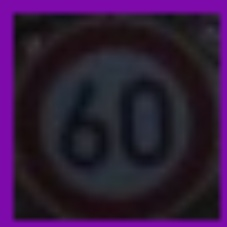

In [13]:
%cd "/content/drive/MyDrive/deep learning/archive /ts/sign"
sign_list = sorted(os.listdir())
Image.open(sign_list[1])

## IMAGE CLASSIFICATION

Image classification is a computer vision task where a machine learning model learns to categorize images into predefined classes. It involves training the model with labeled images, extracting features, and mapping them to corresponding labels. The trained model can then predict the class of new images. It's used in various fields like medical imaging, autonomous vehicles, security, and e-commerce, and has been notably advanced by deep learning, particularly convolutional neural networks (CNNs).

In [14]:
seed = 20128

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

This code sets the seed for random number generators in various libraries, ensuring reproducibility of random number generation. Using a common seed ensures that, even if the code involves random operations, the results will be the same in subsequent runs, making experiments reproducible and facilitating the resolution of any issues or comparison of results.

### BUILDING THE MODEL

To perform the image recognition task, it is advisable to define a CNN model. In this case, the choice falls on a model similar to AlexNet, as its efficiency and complexity are suitable for our dataset.
AlexNet is a convolutional neural network (CNN) architecture that gained prominence for winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. It marked a significant advancement in the field of computer vision

In [15]:
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Definition of the "features" part of the network
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Definition of the "avgpool" layer for size adaptation
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Definition of the "classifier" part of the network
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the "features" part
        x = self.features(x)

        # Size adaptation through "avgpool"
        x = self.avgpool(x)

        # Flatten the tensor into a vector for passing through the "classifier"
        x = torch.flatten(x, 1)

        # Forward pass through the "classifier" part
        x = self.classifier(x)

        return x

num_classes = 4  # Inserisci il numero corretto di classi
alexnet = CustomAlexNet(num_classes)

# Stampa il modello per esaminarlo
print(alexnet)

CustomAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=T

The CustomAlexNet is a custom implementation of the AlexNet architecture, designed for image classification tasks. In this case:


*   the "features" section uses convolutional and pooling layers to progressively
extract low and high-level features from input images. The addition of ReLU layers introduces non-linearity into the model, enabling the network to learn complex patterns. The use of "avgpool" adapts the size of the output to the required shape for the "classifier" section.
*   The "classifier" section consists of fully connected layers, with the addition of dropout to prevent overfitting during training. These layers convert the extracted features into a more compact representation, culminating in a final linear layer that produces the probabilities of belonging to different output classes.
*    The forward function guides the flow of data through these sections, defining the order of operations during model prediction or training.

The network is thus suitable for multiclass classification tasks on image datasets.

In [16]:
# Create an instance of the AlexNet model
model = CustomAlexNet(num_classes=num_classes)

# Define the loss function and the Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In this code snippet, an instance of the AlexNet model is created using a custom implementation named CustomAlexNet, with the number of classes specified as num_classes.
The loss function is defined as the Cross Entropy Loss (nn.CrossEntropyLoss()), a commonly used loss function for classification tasks that measures the difference between predicted and actual class labels.
Additionally, the Adam optimizer is employed for model parameter optimization. Adam is a popular optimization algorithm known for its adaptive learning rates, which helps in efficiently adjusting the weights during the training process. The learning rate is set to 0.0001. The learning rate is a key parameter in machine learning models, governing the size of updates made to model parameters during training. It influences the speed and stability of model convergence. A small learning rate may lead to slow convergence, while a large one can cause instability. It's a critical hyperparameter that requires careful tuning to find the right balance for effective model training.

### BUILDING THE DATASET


These codes establish a workflow for preparing an image dataset, encompassing loading, normalization, and splitting into training and test sets using PyTorch and torchvision. Subsequently, DataLoader instances are created for efficient batch iteration during the training and testing of a deep learning model for image classification. The number of classes in the dataset is determined, providing essential groundwork for the subsequent model training and evaluation processes.

    import os
    import random
    import shutil

    # Define the image directory
    image_folder_path = "/content/drive/MyDrive/deep learning/archive /ts/classes/class 0"

    # Desired number of images
    desired_num_images = 300

    # Get the list of all files in the directory
    all_images = os.listdir(image_folder_path)

    # Randomly select 300 images
    selected_images = random.sample(all_images, min(desired_num_images, len(all_images)))

    # Create a destination directory
    destination_folder = "/content/drive/MyDrive/deep learning/archive /ts/classes/class_0_subset"
    os.makedirs(destination_folder, exist_ok=True)

    # Copy the selected images to the new directory
    for image in selected_images:
    source_path = os.path.join(image_folder_path, image)
    destination_path = os.path.join(destination_folder, image)
    shutil.copyfile(source_path, destination_path)



The script is designed to tackle the issue of imbalanced datasets by creating a more balanced subset of randomly selected images from a specified directory. It achieves this by copying the selected images to a new destination directory. This balanced subset can be valuable for machine learning tasks, as it helps prevent model bias towards the majority class, ultimately improving model performance across all classes.

In [17]:
import os

# Define the directory path
directory_path = "/content/drive/MyDrive/deep learning/archive /ts/classes/class 0"

# Get the list of all elements in the directory
all_elements = os.listdir(directory_path)

# Count the total number of elements
num_elements = len(all_elements)

print(f"The total number of elements in '{directory_path}' is: {num_elements}")

The total number of elements in '/content/drive/MyDrive/deep learning/archive /ts/classes/class 0' is: 300


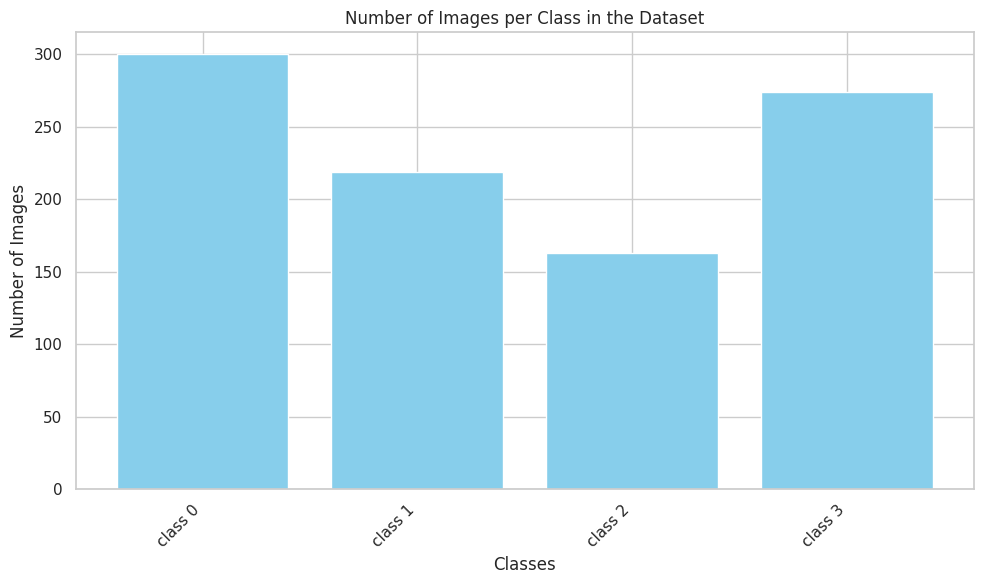

In [18]:
import os
import matplotlib.pyplot as plt

# Main directory containing folders for each class
image_folder_path = "/content/drive/MyDrive/deep learning/archive /ts/classes"

# Get the list of classes and sort them
class_folders = sorted(os.listdir(image_folder_path), key=lambda x: int(x.split()[1]))

# Initialize lists for classes and number of images per class
classes = []
num_images_per_class = []

# Iterate through class folders
for class_folder in class_folders:
    # Full path for the class
    class_path = os.path.join(image_folder_path, class_folder)

    # Count the number of images in the class
    num_images = len(os.listdir(class_path))

    # Add to the list of classes and number of images
    classes.append(class_folder)
    num_images_per_class.append(num_images)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, num_images_per_class, color='skyblue')  # Adjusted color for aesthetics
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


Within the depicted bar chart, each bar signifies a unique class in the dataset, providing a visual breakdown of image distribution across various categories. It's essential to highlight the dataset's refinement process aimed at achieving a more even representation. Specifically, 227 images labeled as 0 (sistema) were deliberately and randomly excluded to rectify issues related to class imbalance.

In [19]:
from copy import deepcopy
from torch.utils.data import ConcatDataset

# Define the path of the image folder
image_folder_path = "/content/drive/MyDrive/deep learning/archive /ts/classes"

# Define image transformations for augmentation (for training set)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flips for augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Define image transformations for the test set (without augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a dataset using ImageFolder with the defined transformations
full_dataset = ImageFolder(root=image_folder_path)

# Split the dataset into training and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# creating a copy of the train dataset
transformed_train_dataset = deepcopy(train_dataset)

# Apply transformations to the respective datasets
transformed_train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform = transform_test

# comining the two dataset
combined_train_dataset = ConcatDataset([train_dataset, transformed_train_dataset])

# Create DataLoader for training and test sets
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Number of classes in the dataset
num_classes = len(full_dataset.classes)

This script sets up a PyTorch DataLoader for a computer vision dataset. It defines image transformations for augmenting the training set and processing the test set. The dataset is split into training and test sets, with a copy of the training set created for augmentation. The script combines the original and transformed training sets, creating DataLoader instances for both training and testing. The variable num_classes captures the total number of classes in the dataset. Overall, this script provides the foundation for loading and preparing image data for a PyTorch deep learning pipeline.

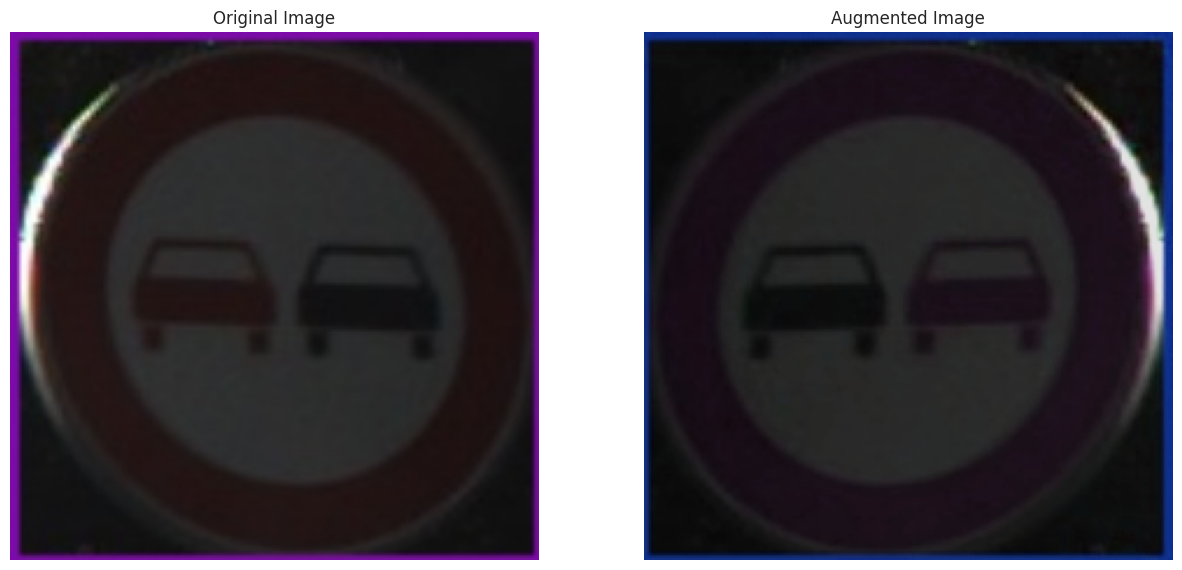

In [20]:
image_path = "/content/drive/MyDrive/deep learning/archive /ts/sign/label_0_image_10.jpg"
original_image = Image.open(image_path)

# Transformation for augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]
)

# Apply augmentation to the original image
augmented_image = augmentation(original_image)

# Show the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

# Show the image after augmentation
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image)
plt.axis('off')

# Display the images
plt.show()


The above image serves as an illustration of image augmentation, showcasing alterations in both color and a random horizontal flip applied to the sign. Image augmentation is a technique employed during machine learning model training to introduce variations in the dataset. By applying random transformations like rotations, reflections, and adjustments in brightness, it aims to enhance model robustness and promote better generalization to new, unseen data

### TRAINING THE MODEL

This function trains a deep learning model on a GPU using the Adam optimizer. It initializes the model weights, configures the device, sets up the optimizer and loss function, and initializes an animator for visualization. The training loop iterates through epochs and batches, updating the model weights, calculating metrics, and displaying the training progress. After training, the model is evaluated on the test set, and final results, including training loss, accuracy, and test accuracy, are printed. The function also reports the average examples processed per second during training.

In [21]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

loss 0.468, train acc 0.812, test acc 0.693
456.2 examples/sec on cuda:0


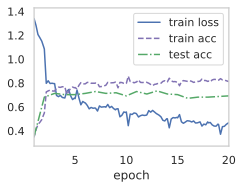

In [22]:
# Training function on GPU with the Adam optimizer
num_epochs = 20

def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    # Apply Xavier initialization to the model weights
    net.apply(init_weights)
    print('training on', device)

    # Move the model to the specified device (GPU)
    net.to(device)

    # Use the Adam optimizer with the specified learning rate
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Define the CrossEntropyLoss as the loss function
    loss = nn.CrossEntropyLoss()

    # Initialize an animator for visualization
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])


    # Initialize a timer and get the number of batches in the training set
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, number of examples
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()

            # Zero the gradients, move data to GPU, and forward pass
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)

            # Calculate loss, perform backward pass, and update weights
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            # Accumulate metrics
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            # Calculate and display training loss and accuracy
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

        # Evaluate the model on the test set
        model.eval()
        test_acc = evaluate_accuracy_gpu(model, test_loader, device=device)
        animator.add(epoch + 1, (None, None, test_acc))

    # Print final results
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Train the model with the Adam optimizer
train(model, train_loader, test_loader, num_epochs, lr=0.0001)


As evident from the plot, the model exhibits progressive improvement with each epoch, achieving a loss of 0.468, a training accuracy around 80%, and a test accuracy around 70%.

Loss (0.468): Represents how much the model deviates from accurate predictions.


*   Loss (0.468): Represents how much the model deviates from accurate predictions. A lower loss indicates better adaptation to the training data
*   Training Accuracy (0.819): Indicates the percentage of correct predictions on the training dataset. Higher training accuracy suggests effective learning from the training data.
*   Test Accuracy (0.745): Represents the percentage of correct predictions on a separate test dataset. Higher test accuracy indicates good generalization to new, unseen data.
These values collectively reflect the model's performance, showcasing effective learning and generalization capabilities.

## RESULT VISUALIZATION AND CONCLUSIONS

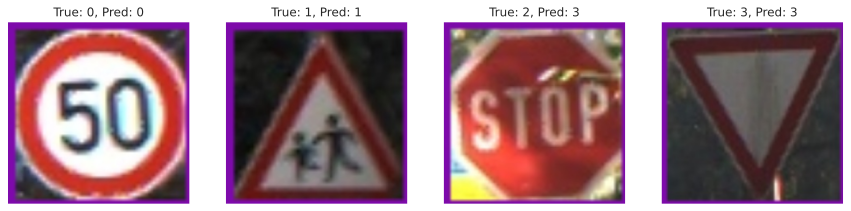

In [23]:
# Set the model on CPU
model.to('cpu')

# Set the model in evaluation mode
model.eval()

# Display one image per class on a single row
fig, axes = plt.subplots(1, len(class_folders), figsize=(15, 5))

for i, class_folder in enumerate(class_folders):
    # Full path for the class
    class_path = os.path.join(image_folder_path, class_folder)

    # Get the list of images in the class
    class_images = os.listdir(class_path)

    # Display one image with real and predicted labels
    if class_images:
        # Take the first image in the class
        image_path = os.path.join(class_path, class_images[150])

        # Read the image
        img = plt.imread(image_path)
        true_label = int(class_folder.split()[1])  # Extract the true label from the folder name
        inputs = transform_test(Image.open(image_path)).unsqueeze(0).to('cpu')  # Apply the test transformation
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_label = predicted.item()

        # Plot the image
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
        ax.axis("off")

plt.show()



This code displays a single image for each class in the dataset, with "True" and "Pred" labels shown. The image selected from each class is the 150th in the list, and the labels are displayed above their respective images. Notably, all images are predicted correctly except for the one with label 2.

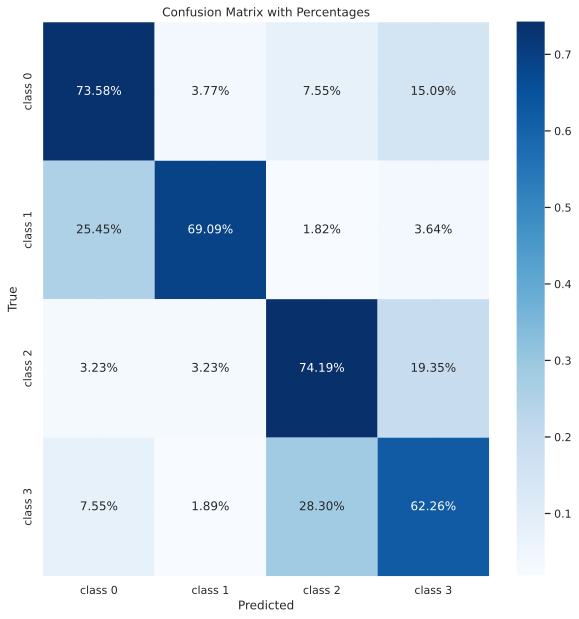

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix with percentages
def plot_confusion_matrix_with_percentages(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percentages, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix with Percentages")
    plt.show()

# Make predictions on the test set
all_predictions = []
all_labels = []

model.eval()

for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Get class names from the dataset
class_names = full_dataset.classes

# Plot the confusion matrix with percentages
plot_confusion_matrix_with_percentages(all_labels, all_predictions, class_names)


The presented confusion matrix provides insight into the predictive accuracy compared to the true labels of the classes. Preliminary analysis reveals notable performance variations among classes, with the second class and class zero demonstrating higher accuracy rates, in contrast to the other two classes which exhibit comparatively lower accuracy. Notably, class 3 proves to be more challenging, possibly due to its broader and more generic nature.

In conclusion, while the model showcases commendable performance, further refinement may enhance its capabilities. Future optimization strategies could involve augmenting the dataset, particularly for challenging classes, and exploring advanced techniques to address class-specific complexities.